<a href="https://colab.research.google.com/github/marianna13/GNN_Krasnodar/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 239.1 MB 23 kB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 281 kB 18.1 MB/s 
     |████████████████████████████████| 36.8 MB 25 kB/s 
     |████████████████████████████████| 109 kB 67.9 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 45 kB 1.5 MB/s 
     |████████████████████████████████| 103 kB 67.4 MB/s 
     |████████████████████████████████| 41 kB 408 kB/s 
     |████████████████████████████████| 3.2 MB 37.4 MB/s 
     |████████████████████████████████| 546 kB 63.5 MB/s 
     |████████████████████████████████| 133 kB 72.8 MB/s 
     |████████████████████████████████| 1.1 MB 16.6 MB/s 
     |████████████████████████████████| 84 kB

# Dataset

In [105]:
import pandas as pd
import networkx as nx
import dgl
import torch.nn as nn
import torch
import torch.nn.functional as F
import itertools
import numpy as np
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10, 6))
torch.manual_seed(0)

def distance(lat1, lat2, lon1, lon2):

    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

    c = 2 * asin(sqrt(a))

    r = 6371

    return(c * r)

def extract_time(t: str) -> float:
    if 'час' in t:
        if 'мин' in t:
            h, m = t.replace(' мин', '').replace(' час', '').split()
        else:
            h = t.replace(' час', '')
            m = 0
        t = int(h)*60+int(m)
        return float(t)
    return float(t.replace(' мин', ''))

def extract_distance(d: str) -> float:
    return float(d.split()[0])

data = pd.read_excel('/content/data_gis_3600.xlsx', index_col=0)
data['time'] = data.time.apply(extract_time)
data['distance'] = data.distance.apply(extract_distance)
print(data.time.max())

bins = [i for i in range(0, 80, 3)]
labels = [i for i in range(len(bins)-1)]
data['label'] = pd.cut(data.time, bins=bins, labels=labels).astype(np.int8)
# data = data.drop_duplicates(subset=['lat1', 'lon1', 'lat2', 'lon2'])
transports = pd.read_excel('/content/transports_3600.xlsx', index_col=0)
G = nx.Graph()

n_feat = []
lats = pd.concat([data['lat1'], data['lat2']]).values
longs = pd.concat([data['lon1'], data['lon2']]).values

points = list(set(zip(lats, longs)))

for point in points:
    lat, lon = point
    G.add_node(point, pos=(lat, lon))
    n_feat.append(transports[transports['lat'].isin([lat]) & transports['lon'].isin([lon])]['transport'].values[0]+1)

  

e_feat = []
e_labels = {} 


for row in tqdm(data.iterrows(), total=len(data)):
    lat1, lon1, lat2, lon2, time, d, label = row[1].values
    weight = time
    color = (0.1*weight/10, 0.2, 0.5)
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    if not G.get_edge_data(point2, point1) and d<7:
      G.add_edge(point1, point2, weight=weight, color=color)
      e_feat.append(d)
      e_labels[(point1, point2)] = label

scaler = StandardScaler()
n_feat = list(scaler.fit_transform(np.array(n_feat).reshape(-1, 1)).reshape(len(n_feat)))

75.0


100%|██████████| 1243/1243 [00:00<00:00, 26347.01it/s]


(397, 580, 4)


(38.9, 39.1, 44.98, 45.1)

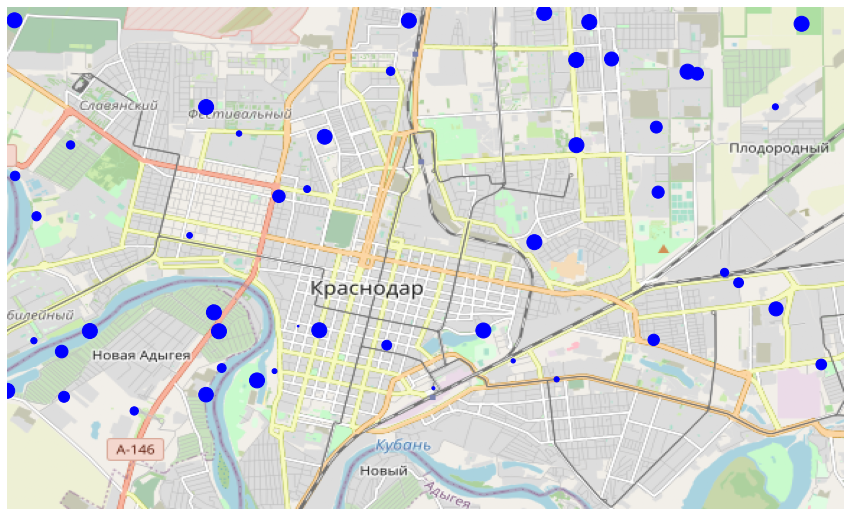

In [ ]:
krasnodar = plt.imread('/content/map.png')
print(krasnodar.shape)
BBox = (38.9, 39.1,44.98, 45.1)
fig, ax = plt.subplots(figsize = (15, 14))
ax.scatter(transports.lat, transports.lon, zorder=1, c='blue', s=n_feat)
ax.imshow(krasnodar, zorder=0, extent = BBox)
plt.axis('off')

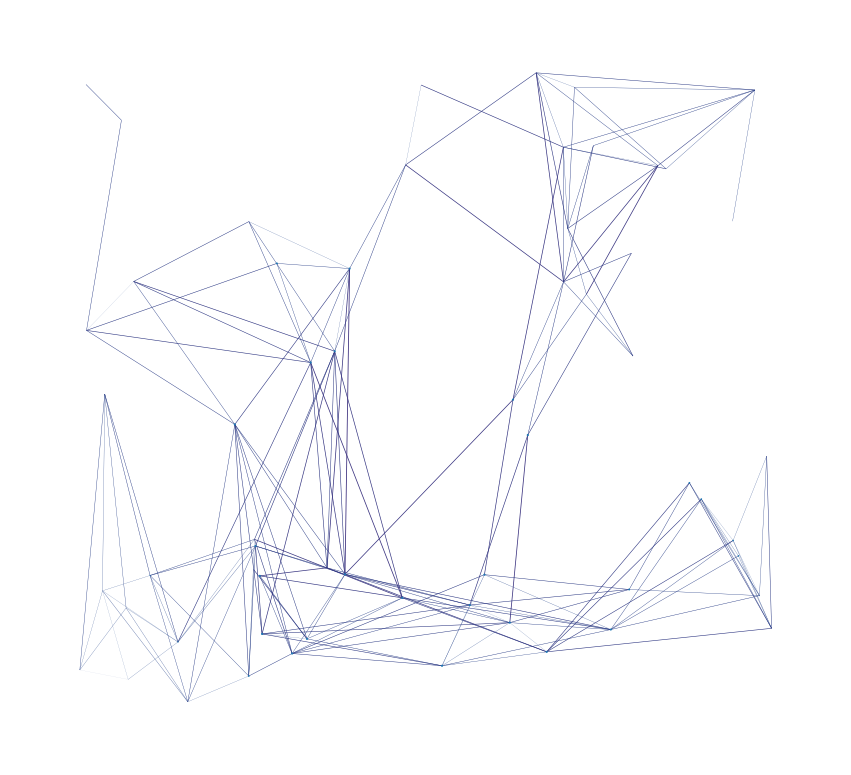

In [101]:
edges = G.edges()
pos = nx.get_node_attributes(G,'pos')
colors = [G[u][v]['color'] for u, v in edges]
fig, ax = plt.subplots(figsize = (15, 14))
weights = [G[u][v]['weight']/30 for u, v in edges]
# plt.imshow(krasnodar, zorder=0, extent = BBox)
nx.draw(G, edge_color=colors, width=weights, pos=pos, node_size=n_feat)

# GNN

In [81]:
len(e_feat), len(G.edges), len(e_labels), len(n_feat), len(G.nodes)

(1014, 1014, 1014, 60, 60)

In [106]:
edge_pred_graph = dgl.from_networkx(G)

# edge_pred_graph = dgl.graph((np.concatenate([src_edges, dst_edges]), np.concatenate([src_edges, dst_edges])))
edge_pred_graph.edata['feature'] = torch.FloatTensor(e_feat*2)
edge_pred_graph.ndata['feature'] = torch.FloatTensor(n_feat)
# edge_pred_graph.ndata['feature'] = torch.randn(len(n_feat))
edge_pred_graph.edata['label'] = torch.tensor(list(e_labels.values())*2)
edge_pred_graph.edata['train_mask'] = torch.zeros(len(list(e_labels.values())*2), dtype=torch.bool).bernoulli(0.8)

In [13]:
import dgl.function as fn
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [14]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [28]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dgl.nn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dgl.nn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

In [117]:
from sklearn.metrics import mean_squared_error, accuracy_score

n_nodes = len(G.nodes)
node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']
model = Model(n_nodes, 1000, n_nodes)
opt = torch.optim.Adam(model.parameters())
losses = []
t_losses = []
EPOCHS = 300
for epoch in range(EPOCHS):   
    pred = model(edge_pred_graph, node_features)
    loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
    losses.append(loss.detach().numpy())
    test_loss = ((pred[~train_mask] - edge_label[~train_mask]) ** 2).mean()
    t_losses.append(test_loss.detach().numpy())
    if epoch%10==0:
      y_pred = np.round(pred[~train_mask].detach().numpy())
      y_test = np.array(edge_label[~train_mask])
      mse = mean_squared_error(y_test, y_pred)
      print(f'epoch: {epoch} loss: {loss.item():.3f} - val_loss {test_loss.item():.3f} - val_rmse {np.sqrt(mse):.3f}')

    opt.zero_grad()
    loss.backward()
    opt.step()
   

epoch: 0 loss: 13.267 - val_loss 16.919 - val_rmse 4.169
epoch: 10 loss: 3.360 - val_loss 5.470 - val_rmse 2.308
epoch: 20 loss: 2.213 - val_loss 4.597 - val_rmse 2.162
epoch: 30 loss: 2.047 - val_loss 4.127 - val_rmse 2.064
epoch: 40 loss: 1.933 - val_loss 4.109 - val_rmse 2.009
epoch: 50 loss: 1.904 - val_loss 4.039 - val_rmse 1.996
epoch: 60 loss: 1.891 - val_loss 4.098 - val_rmse 2.000
epoch: 70 loss: 1.886 - val_loss 4.004 - val_rmse 1.983
epoch: 80 loss: 1.885 - val_loss 4.039 - val_rmse 1.991
epoch: 90 loss: 1.884 - val_loss 4.018 - val_rmse 1.943
epoch: 100 loss: 1.884 - val_loss 4.024 - val_rmse 1.991
epoch: 110 loss: 1.884 - val_loss 4.034 - val_rmse 1.991
epoch: 120 loss: 1.884 - val_loss 4.024 - val_rmse 1.991
epoch: 130 loss: 1.884 - val_loss 4.032 - val_rmse 1.991
epoch: 140 loss: 1.884 - val_loss 4.028 - val_rmse 1.991
epoch: 150 loss: 1.884 - val_loss 4.029 - val_rmse 1.991
epoch: 160 loss: 1.884 - val_loss 4.029 - val_rmse 1.991
epoch: 170 loss: 1.884 - val_loss 4.029 

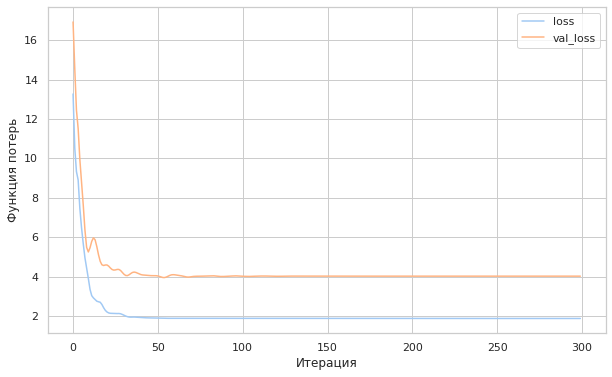

In [118]:
# losses = losses[100:]
# t_losses = t_losses[100:]
plt.plot(np.arange(len(losses)), losses, label='loss')
plt.plot(np.arange(len(t_losses)), t_losses, label='val_loss')
plt.ylabel('Функция потерь')
plt.xlabel('Итерация')
plt.legend(loc='upper right')
plt.show()

# XGB regression

In [119]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = np.array(data['distance']).reshape(len(data['distance']), 1)
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 100)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))

(1243, 1) (1243,)
2.3838456
